In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from itertools import product
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset,random_split, ConcatDataset
from torchvision import datasets, transforms

import netCDF4 as nc
from scipy.ndimage import zoom

npyPath = "skogsstyrelsen-data"
ncPath = "skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria"
npyFiles =["skogs_json_test.npy", "skogs_json_train.npy", "skogs_json_val.npy"]


In [2]:
def npy_loader():
    
    
    # Initialize data_list outside the loop
    data_list = []

    # Load and print contents of each file
    for file_name in npyFiles:
        full_path = os.path.join(npyPath, file_name)  # Include folder path
        if os.path.exists(full_path):  # Ensure file exists
            data = np.load(full_path, allow_pickle=True)  # Load the .npy file
            # Extract 'ValideringsobjektBildId' and 'MolnDis' from each JSON line
            if isinstance(data, np.ndarray) and data.size > 0 and isinstance(data[0], dict):
                for item in data:
                    valideringsobjekt_bild_id = item.get('ValideringsobjektBildId', 'N/A')
                    moln_dis = item.get('MolnDis', 'N/A')
                    # Add to a list of lists
                    data_list.append([valideringsobjekt_bild_id, moln_dis])
            else:
                print(f"File {file_name} does not contain the expected JSON data.")
        else:
            print(f"File {file_name} does not exist.")
    print(f"Loaded {len(data_list)} items.")
    return data_list


In [3]:

def combine_bands(data_list):
    bands = ['b02', 'b03', 'b04', 'b11']
    target_shape = (21, 21)  # Ensure uniform size
    max_channels = 4  

    features = []
    labels = []

    for item in data_list:
        file_id, label = item
        file_path = os.path.join(ncPath, f'skgs_{file_id}.nc')

        try:
            with nc.Dataset(file_path, 'r') as dataset:
                resampled_bands = []

                for band in bands:
                    if band in dataset.variables:
                        band_data = dataset.variables[band][0, :, :]  # Extract first time slice
                        band_data = np.nan_to_num(band_data, nan=0.0)  # Replace NaNs with 0

                        # Resize if necessary
                        if band_data.shape != target_shape:
                            print(f"Resizing {file_id}: {band_data.shape} → {target_shape}")
                            band_data = np.resize(band_data, target_shape)

                        resampled_bands.append(band_data)
                    else:
                        print(f"Warning: {band} not found in {file_path}")
                        resampled_bands.append(np.zeros(target_shape))  # Default empty band

                # Ensure we always have (4, 21, 21)
                combined_bands = np.stack(resampled_bands, axis=0)  # (C, H, W)
                print(f"Final processed shape: {combined_bands.shape}")  # Debugging

                features.append(combined_bands)
                labels.append(label)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    print(f"Processed {len(features)} samples.")

    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.int64)


Loaded 432 items.
Final processed shape: (4, 21, 21)
Final processed shape: (4, 21, 21)
Resizing ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (21, 21)
Resizing ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (21, 21)
Resizing ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (21, 21)
Resizing ee53636e-47c7-ed11-9174-005056a6f472: (20, 20) → (21, 21)
Final processed shape: (4, 21, 21)
Resizing 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Resizing 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Resizing 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Resizing 6a61b1e6-45c7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Final processed shape: (4, 21, 21)
Resizing 50b88b11-3ec7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Resizing 50b88b11-3ec7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Resizing 50b88b11-3ec7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Resizing 50b88b11-3ec7-ed11-9174-005056a6f472: (21, 20) → (21, 21)
Final processed shape: (4, 21, 21)
Res

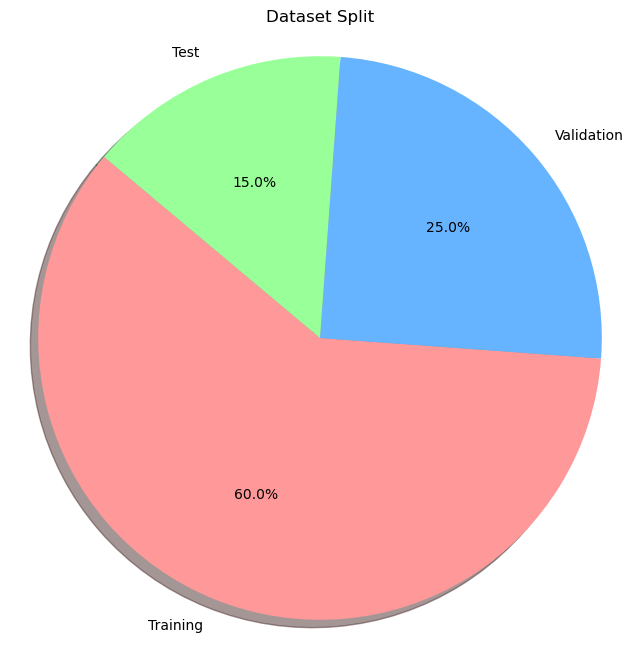

In [4]:

class SatelliteDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        """
        Args:
            features (numpy array or torch.Tensor): Multi-band satellite images (shape: N x C x H x W).
            labels (numpy array or torch.Tensor): Binary labels (0 or 1).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.features = torch.tensor(features, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert to tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]  # Get image (shape: C x H x W)
        label = self.labels[idx]    # Get corresponding label

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

features, labels = combine_bands(npy_loader())
print(features.shape, labels.shape)
# Define the transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping
    transforms.RandomRotation([90, 90]),      # Random rotation up to 40 degrees
    transforms.Normalize((0.0,), (1.0,))  # Normalize values to [0, 1]
])

transform_normalize = transforms.Compose([
    transforms.Normalize((0.0,), (1.0,))  # Normalize values to [0, 1]
])

#dataset_transform = SatelliteDataset(features, labels, transform=transform)
dataset = SatelliteDataset(features, labels,transform=transform_normalize)






# notes
# tensor inside transform
# apply transform to to train dataset only
# padding 
# only transform cloudy pictures
# different ways of balance cloud or not cloud





# Combine both datasets
#combined_dataset = ConcatDataset([dataset, dataset_transform])

# Random split of the data
validation_split = 0.25
train_split = 0.6
test_split = 0.15

# Define the sizes for each split
train_size = int(train_split * len(dataset))
val_size = int(validation_split * len(dataset))
test_size = len(dataset) - train_size - val_size


# Set random seed for reproducibility
generator = torch.Generator().manual_seed(31)

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform_normalize
test_dataset.dataset.transform = transform_normalize

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Function to plot images from datasets




print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))


# Pie chart of dataset splits
sizes = [train_size, val_size, test_size]
labels = ['Training', 'Validation', 'Test']
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 8))
plt.pie(sizes,labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=140)
plt.title('Dataset Split')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [5]:
import matplotlib.pyplot as plt
from sklearn import metrics
import torch

# Confusion matrix
import torch
import matplotlib.pyplot as plt
from sklearn import metrics

def confusion_matrix(model, test_loader, model_path='best_model.pth', class_labels=[0, 1]):
    
    # Load the trained model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_labels = []
    all_predictions = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)

    # Set up the figure with a proper aspect ratio
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    # Adjust layout for a cleaner look
    plt.tight_layout()
    plt.show()


In [6]:


class CloudDetectionCNN(nn.Module):
    def __init__(self):
        super(CloudDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)  # First convolutional layer

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Third convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.fc1 = nn.Linear(128 * 2 * 2, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 2)  # Second fully connected layer (output layer)
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Apply conv1, ReLU, and max pooling
        x = self.pool(self.relu(self.conv2(x)))  # Apply conv2, ReLU, and max pooling
        x = self.pool(self.relu(self.conv3(x)))  # Apply conv3, ReLU, and max pooling
        x = x.view(-1, 128 * 2 * 2)  # Flatten the tensor
        x = self.relu(self.fc1(x))  # Apply fc1 and ReLU
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Apply fc2 (output layer)
        return x

model = CloudDetectionCNN()

Epoch 1/60, Loss: 27.263751453823513
Validation Loss: 1.4652713239192963, Accuracy: 74.07407407407408%
Epoch 2/60, Loss: 3.4174138837390475
Validation Loss: 1.0408639162778854, Accuracy: 75.92592592592592%
Epoch 3/60, Loss: 1.3999449587944481
Validation Loss: 0.788131408393383, Accuracy: 78.70370370370371%
Epoch 4/60, Loss: 0.7936642699771457
Validation Loss: 0.5361220315098763, Accuracy: 77.77777777777777%
Epoch 5/60, Loss: 0.6379690004719628
Validation Loss: 0.5780671015381813, Accuracy: 85.18518518518519%
Epoch 6/60, Loss: 0.514669742849138
Validation Loss: 0.4224211499094963, Accuracy: 84.25925925925925%
Epoch 7/60, Loss: 0.37437394923634
Validation Loss: 0.3905140422284603, Accuracy: 85.18518518518519%
Epoch 8/60, Loss: 0.42113301489088273
Validation Loss: 0.47342807054519653, Accuracy: 80.55555555555556%
Epoch 9/60, Loss: 0.43449488116635215
Validation Loss: 0.4472421556711197, Accuracy: 88.88888888888889%
Epoch 10/60, Loss: 0.36972833010885453
Validation Loss: 0.4180641770362854

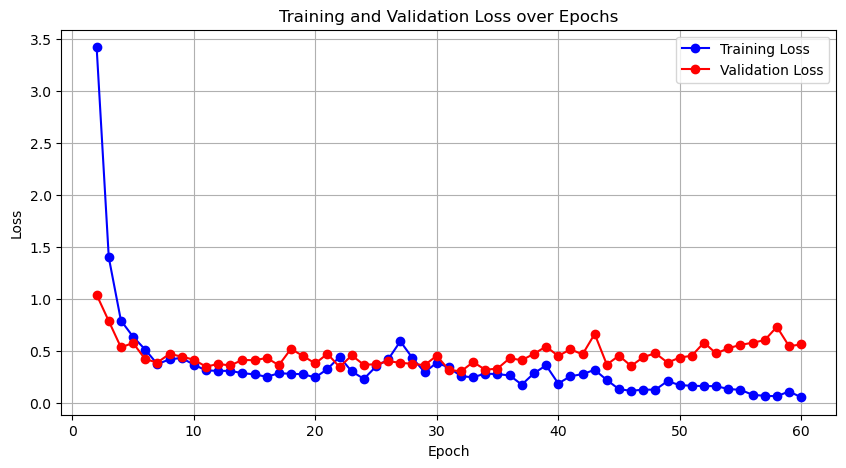

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss = []
val_loss_array = []
# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    train_loss.append(running_loss/len(train_loader))
    

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Save the best model
        
        # Save the best model based on validation accuracy
        if epoch == 0 or (100 * correct / total) > best_accuracy:
            best_accuracy = 100 * correct / total
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'cloudclass.pth')
    val_loss_array.append(val_loss/len(val_loader))

    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")
print(f"Best validation accuracy: {best_accuracy}%")

# Plot training and validation loss, skipping the first epoch
plt.figure(figsize=(10, 5))
plt.plot(range(2, num_epochs + 1), train_loss[1:], marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(2, num_epochs + 1), val_loss_array[1:], marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\JuliusAdmin\AppData\Local\Temp\ipykernel_32988\2540153865.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cloudclass.pth'))
C:

Test Loss: 0.3528700666962929, Accuracy: 84.61538461538461%


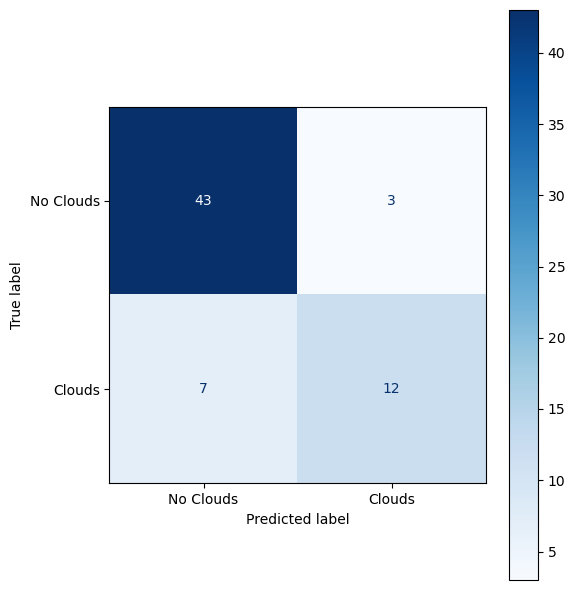

In [8]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    # Load the best model weights
    model.load_state_dict(torch.load('cloudclass.pth'))
    
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%")

confusion_matrix(model, test_loader, model_path='cloudclass.pth', class_labels=['No Clouds', 'Clouds'])


---

# ANN-Model

Define class and functions

In [9]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.2) # Dropout for regularization

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(64, num_classes) 

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu3(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    
    train_loss_array = []
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss/len(train_loader)
        train_loss_array.append(training_loss)

        # Validation
        val_loss, val_acc, _, _ = test_model(val_loader, model)

        # Save the best model based on validation accuracy
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'cloudclass.pth')


        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print(f"Best validation accuracy: {best_accuracy}%")
    
    return model


def test_model(loader, model = None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        # Load the best model weights
        if model == None:
            model.load_state_dict(torch.load('cloudclass.pth'))

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            all_labels.extend(labels)
            all_preds.extend(predicted)
        
        loss = running_loss/len(loader)
        accuracy = 100 * correct / total
            
    return loss, accuracy, np.array(all_labels), np.array(all_preds)


def plot_confusion_matrix(all_labels = None, all_predictions = None, class_labels = [0, 1]):
    
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
    
    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)

    print(cm)

    # Set up the figure with a proper aspect ratio
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    # Adjust layout for a cleaner look
    plt.tight_layout()
    plt.show()

In [10]:
# Labels aus dem Trainingsset extrahieren
train_labels = [label for _, label in train_dataset]

# Anzahl der Samples pro Klasse berechnen
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)

# Gewichte berechnen (inverse Häufigkeit)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

Initialise and run model

Epoch 1/200, Train Loss: 0.6146, Val Loss: 0.4673, Train Acc: 75.68%, Val Acc: 73.85%
Epoch 2/200, Train Loss: 0.4896, Val Loss: 0.4627, Train Acc: 84.17%, Val Acc: 73.85%
Epoch 3/200, Train Loss: 0.4362, Val Loss: 0.4466, Train Acc: 86.87%, Val Acc: 63.08%
Epoch 4/200, Train Loss: 0.3390, Val Loss: 0.3661, Train Acc: 86.87%, Val Acc: 76.92%
Epoch 5/200, Train Loss: 0.3377, Val Loss: 0.3443, Train Acc: 86.49%, Val Acc: 72.31%
Epoch 6/200, Train Loss: 0.2901, Val Loss: 0.7771, Train Acc: 88.03%, Val Acc: 32.31%
Epoch 7/200, Train Loss: 0.2659, Val Loss: 0.3227, Train Acc: 89.96%, Val Acc: 75.38%
Epoch 8/200, Train Loss: 0.2069, Val Loss: 0.3392, Train Acc: 91.89%, Val Acc: 61.54%
Epoch 9/200, Train Loss: 0.2108, Val Loss: 0.2973, Train Acc: 92.66%, Val Acc: 73.85%
Epoch 10/200, Train Loss: 0.2802, Val Loss: 0.2677, Train Acc: 91.12%, Val Acc: 78.46%
Epoch 11/200, Train Loss: 0.1741, Val Loss: 0.2728, Train Acc: 94.21%, Val Acc: 81.54%
Epoch 12/200, Train Loss: 0.1875, Val Loss: 0.2609, 

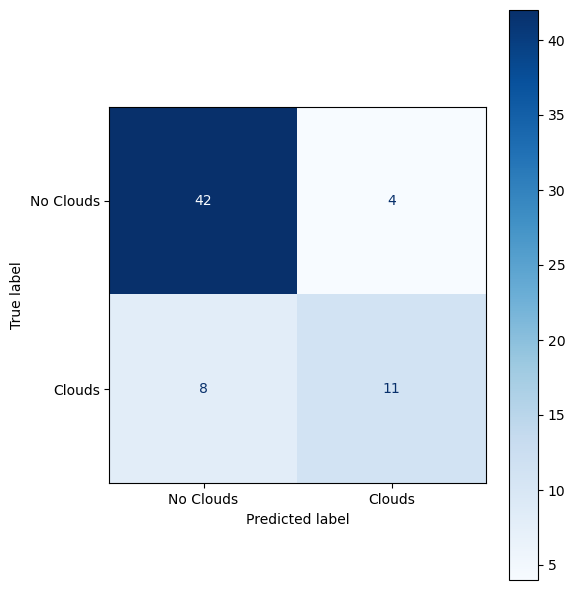

In [11]:
# Initilisation and training
input_size = 21 * 21 * 4
num_classes = 2
num_epochs = 200

model = ANNClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss(weight = class_weights)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
_, test_acc, all_labels, all_preds = test_model(test_loader, model)
print(f'Test Accuracy: {test_acc:.2f}%')
plot_confusion_matrix(all_labels, all_preds, class_labels=['No Clouds', 'Clouds'])